In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx

from scipy.stats import chi2_contingency, f_oneway

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from mlxtend.frequent_patterns import apriori, association_rules


In [2]:
telco_dataset = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
# missing values
na_counts = telco_dataset.isna().sum()
columns_with_na = na_counts[na_counts>0]
print(columns_with_na)
telco_dataset['TotalCharges'].fillna(0, inplace=True)
# Let's drop the customerID column
telco_dataset = telco_dataset.drop(columns=['customerID'])
print(telco_dataset.columns)

TotalCharges    11
dtype: int64
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


C:\Users\DATA\AppData\Local\Temp\ipykernel_17144\2316830837.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  telco_dataset['TotalCharges'].fillna(0, inplace=True)


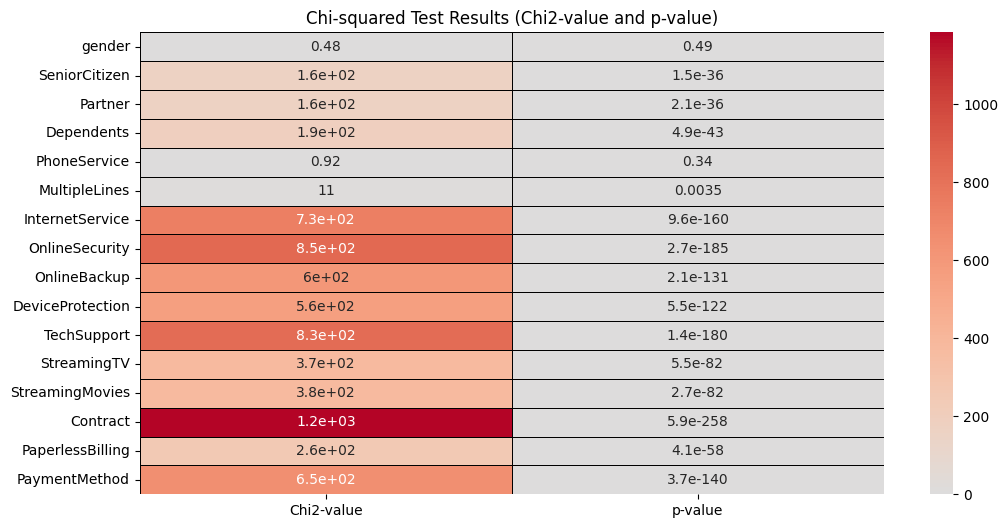

In [ ]:
# Step 1: Chi-Squared Test with Heatmap for Chi2 values and p-values
# Define categorical variables for the chi-squared test
categorical_vars = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# Compute Chi-squared test results
chi2_results = pd.DataFrame(index=categorical_vars, columns=['Chi2-value', 'p-value'])
for var in categorical_vars:
    contingency = pd.crosstab(telco_dataset[var], telco_dataset['Churn'])
    chi2, p, _, _ = chi2_contingency(contingency)
    chi2_results.loc[var, 'Chi2-value'] = chi2
    chi2_results.loc[var, 'p-value'] = p

# Convert results to float for visualization
chi2_results = chi2_results.astype(float)

# Plotting Chi2 and p-values heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(chi2_results, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Chi-squared Test Results (Chi2-value and p-value)')
plt.show()



In [4]:
df_encoded = telco_dataset.copy()

# Step 2: Encoding Categorical Variables
binary_mappings = {
    'gender': {'Female': 0, 'Male': 1},
    'Partner': {'No': 0, 'Yes': 1},
    'Dependents': {'No': 0, 'Yes': 1},
    'PhoneService': {'No': 0, 'Yes': 1},
    'PaperlessBilling': {'No': 0, 'Yes': 1},
    'SeniorCitizen': {0: 0, 1: 1}
}
for col, mapping in binary_mappings.items():
    df_encoded[col] = telco_dataset[col].map(mapping)

# Categorical variables for one-hot encoding
categorical_vars = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaymentMethod'
]

# One-hot encode multi-category variables
df_encoded = pd.get_dummies(df_encoded, columns=categorical_vars, drop_first=True)

# Convert 'Churn' to numeric
df_encoded['Churn'] = df_encoded['Churn'].map({'No': 0, 'Yes': 1})

C:\Users\DATA\AppData\Local\Temp\ipykernel_17144\2726560609.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='viridis')


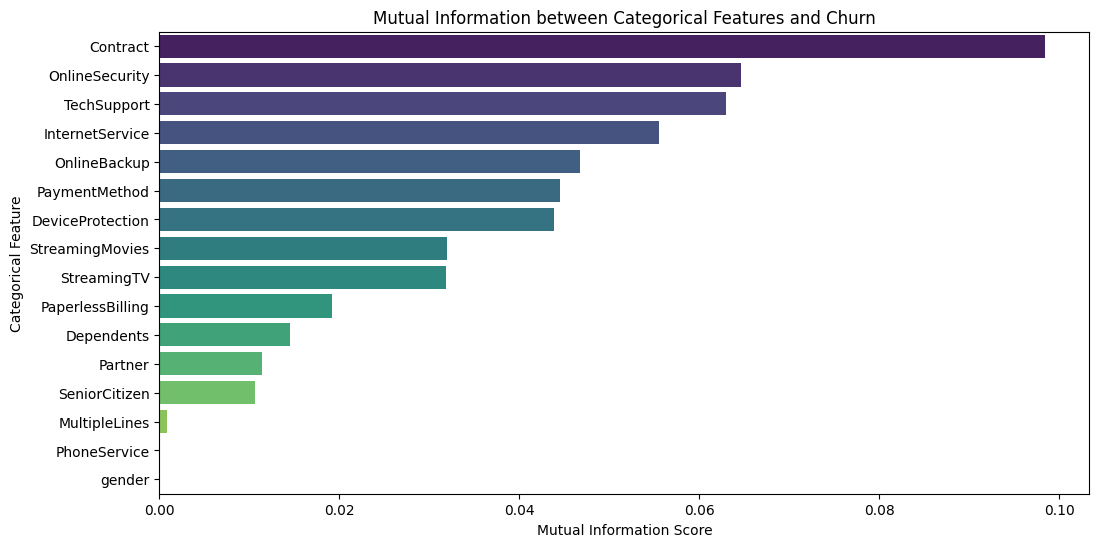

In [ ]:
# Step 1: Prepare the Data
categorical_vars = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# Convert 'Churn' to numeric
telco_dataset['Churn'] = telco_dataset['Churn'].map({'No': 0, 'Yes': 1})

# Apply label encoding for categorical variables
label_encoders = {}
for col in categorical_vars:
    le = LabelEncoder()
    telco_dataset[col] = le.fit_transform(telco_dataset[col])
    label_encoders[col] = le

# Step 2: Mutual Information for Categorical Variables
# Retain only categorical variables and the target
df_categorical = telco_dataset[categorical_vars + ['Churn']]

# Compute mutual information
mi = mutual_info_classif(df_categorical.drop(columns=['Churn']), df_categorical['Churn'], discrete_features=True)

# Step 3: Format Results for Visualization
mi_df = pd.DataFrame({'Feature': df_categorical.drop(columns=['Churn']).columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Step 4: Plot Mutual Information
plt.figure(figsize=(12, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='viridis')
plt.title('Mutual Information between Categorical Features and Churn')
plt.xlabel('Mutual Information Score')
plt.ylabel('Categorical Feature')
plt.show()


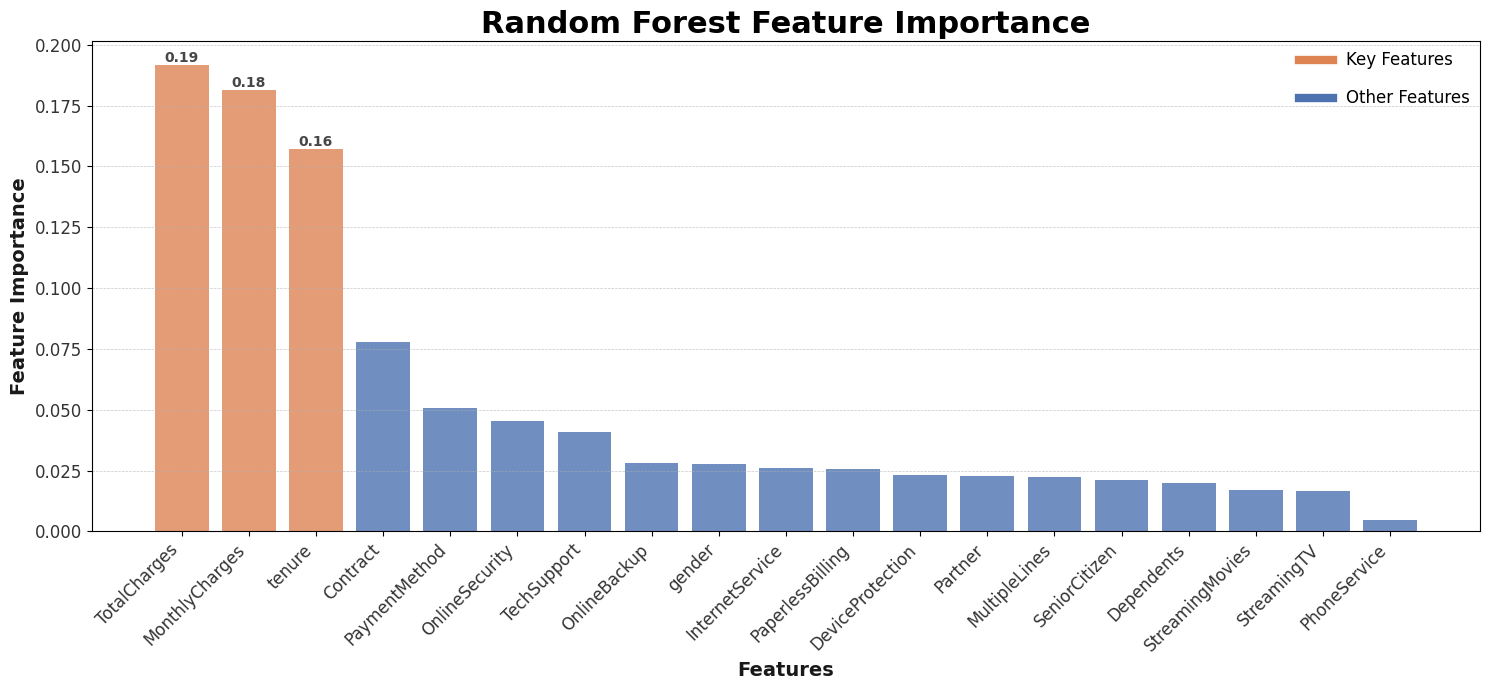

In [ ]:
# Label encoding for categorical variables
label_encoders = {}

for column in telco_dataset.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    telco_dataset[column] = le.fit_transform(telco_dataset[column])
    label_encoders[column] = le

# Define features and target
X = telco_dataset.drop(columns=['Churn'])
y = telco_dataset['Churn']

# Random Forest Classifier for Feature Importance
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
clf.fit(X, y)

# Get feature importances
feature_importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Select the top 19 features
top_n = 19
indices = indices[:top_n]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Highlight the key features
highlighted_features = {'tenure', 'MonthlyCharges', 'TotalCharges'}
colors = ['#4c72b0' if feature not in highlighted_features else '#dd8452' for feature in names]

# Create a bar plot for feature importance
plt.figure(figsize=(15, 7))
plt.title("Random Forest Feature Importance", fontsize=22, weight='bold')
bars = plt.bar(range(top_n), feature_importances[indices], color=colors, edgecolor='none', alpha=0.8)

# Customize x-axis labels
plt.xticks(range(top_n), names, rotation=45, ha='right', fontsize=12, alpha=0.8)
plt.yticks(fontsize=12, alpha=0.8)
plt.ylabel('Feature Importance', fontsize=14, weight='bold', alpha=0.9)
plt.xlabel('Features', fontsize=14, weight='bold', alpha=0.9)

# Add a muted grid to reduce clutter
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Add soft annotations for highlighted features
for bar, feature in zip(bars, names):
    if feature in highlighted_features:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333', alpha=0.9)

# Add a subtle legend for clarity
plt.legend(
    handles=[
        plt.Line2D([0], [0], color='#dd8452', lw=6, label='Key Features'),
        plt.Line2D([0], [0], color='#4c72b0', lw=6, label='Other Features')],
    fontsize=12, loc='upper right', frameon=False, ncol=1, labelspacing=1.2, borderaxespad=0.2
)

plt.tight_layout()
plt.show()


C:\Users\DATA\AppData\Local\Temp\ipykernel_17144\4042680854.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


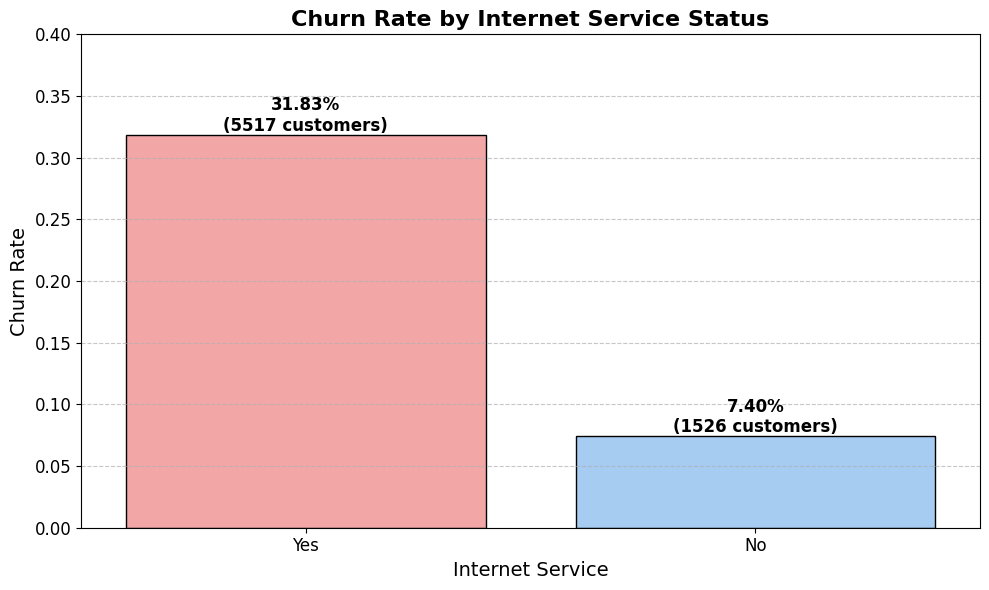

In [ ]:
churn_internet = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")


# Map 'InternetService' to a binary 'No Internet Service' column
churn_internet['No Internet Service'] = churn_internet['InternetService'].apply(lambda x: 1 if x == 'No' else 0)

# Map 'Churn' to binary for calculations
churn_internet['Churn'] = churn_internet['Churn'].map({'No': 0, 'Yes': 1})

# Calculate churn rates for InternetService categories
churn_internet_service = (
    churn_internet.groupby("No Internet Service")["Churn"]
    .mean()
    .reset_index()
    .rename(columns={"Churn": "Churn Rate"})
)

# Add total customer counts for context
customer_counts = (
    churn_internet.groupby("No Internet Service")["Churn"]
    .count()
    .reset_index()
    .rename(columns={"Churn": "Customer Count"})
)
churn_internet_service = churn_internet_service.merge(customer_counts, on="No Internet Service")

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    x="No Internet Service",
    y="Churn Rate",
    data=churn_internet_service,
    palette=["#FF9999", "#99CCFF"],  # Soft red and blue
    edgecolor="black"
)

# Annotate the bar plot
for idx, row in churn_internet_service.iterrows():
    plt.text(
        idx,
        row["Churn Rate"],
        f'{row["Churn Rate"]:.2%}\n({int(row["Customer Count"])} customers)',  # Convert customer count to integer
        ha="center",
        va="bottom",
        fontsize=12,  # Increased font size
        fontweight="bold"  # Bold text
    )

# Formatting
plt.title("Churn Rate by Internet Service Status", fontsize=16, fontweight="bold")
plt.ylabel("Churn Rate", fontsize=14)
plt.xlabel("Internet Service", fontsize=14)  # Corrected label
plt.xticks(ticks=[0, 1], labels=["Yes", "No"], fontsize=12)  # Corrected labels
plt.yticks(fontsize=12)
plt.ylim(0, 0.4)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save and show the plot
plt.savefig("churn_by_internet_service_bold_numbers.png")
plt.show()


ANOVA Test Results for Continuous Variables by Churn:
tenure: F-statistic=997.2680, p-value=0.0000
MonthlyCharges: F-statistic=273.4637, p-value=0.0000
TotalCharges: F-statistic=288.2790, p-value=0.0000


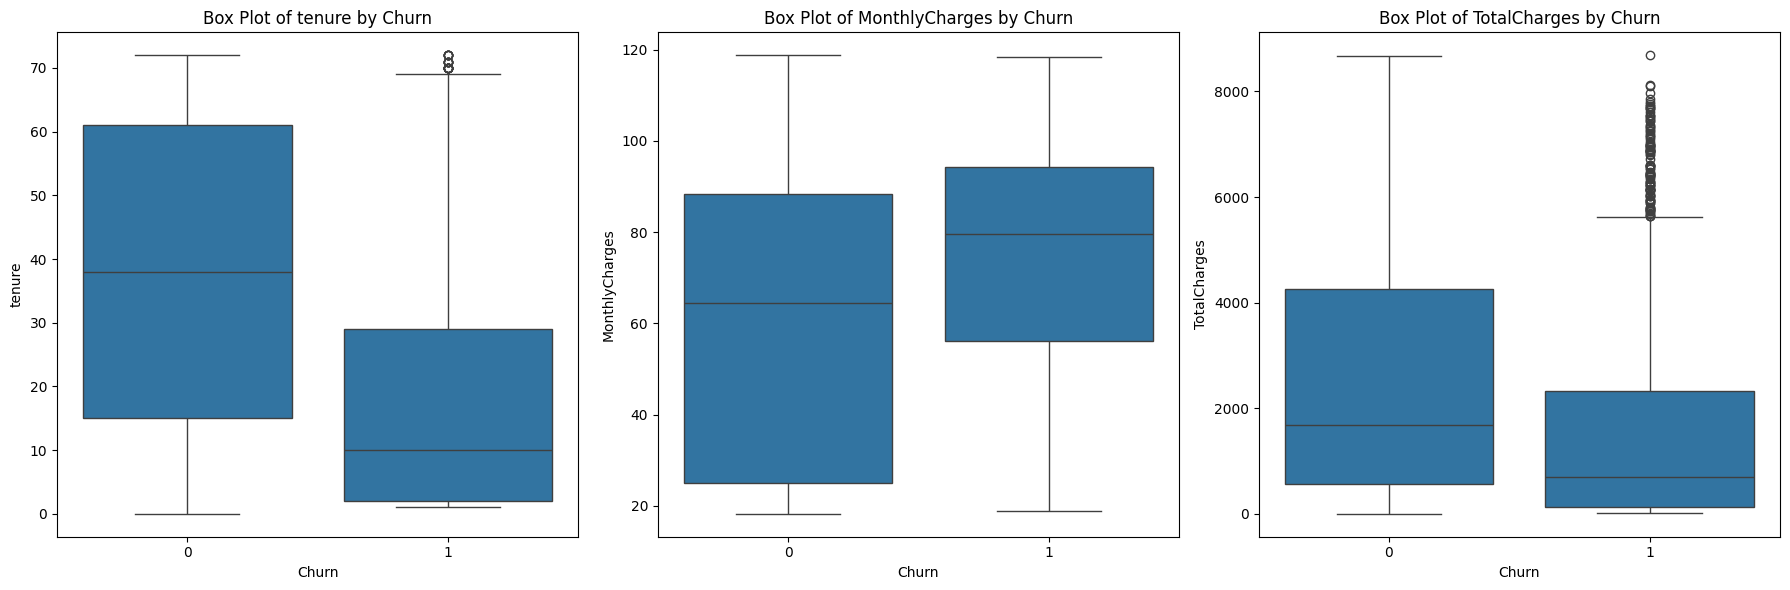

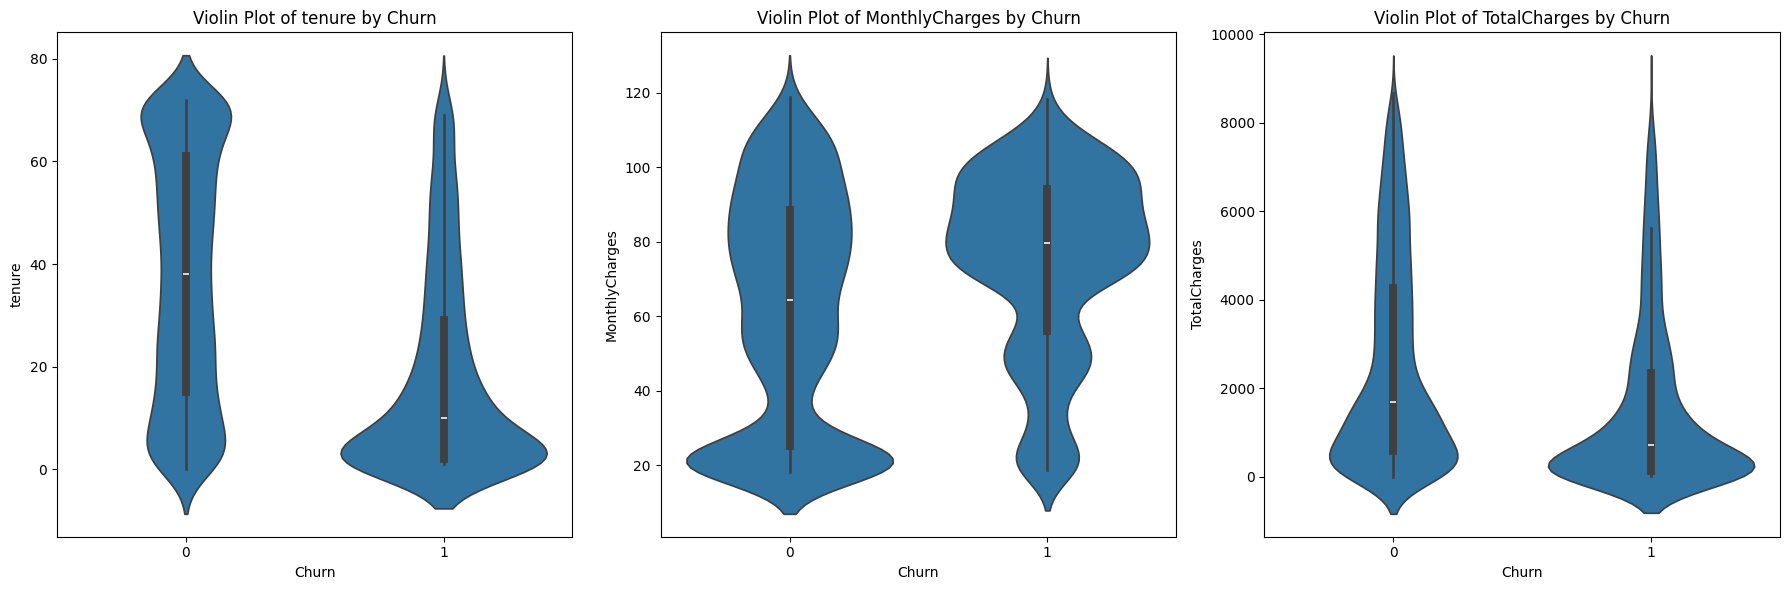

In [8]:
# Step 1: Perform ANOVA test

continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
print("ANOVA Test Results for Continuous Variables by Churn:")
for var in continuous_vars:
    churn_0 = telco_dataset[telco_dataset['Churn'] == 0][var]
    churn_1 = telco_dataset[telco_dataset['Churn'] == 1][var]
    f_stat, p_value = f_oneway(churn_0, churn_1)
    print(f"{var}: F-statistic={f_stat:.4f}, p-value={p_value:.4f}")

# Step 2: Visualization with Box and Violin Plots
plt.figure(figsize=(18, 6))

for i, var in enumerate(continuous_vars, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=var, data=telco_dataset)
    plt.title(f"Box Plot of {var} by Churn")

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))

for i, var in enumerate(continuous_vars, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(x='Churn', y=var, data=telco_dataset)
    plt.title(f"Violin Plot of {var} by Churn")

plt.tight_layout()
plt.show()

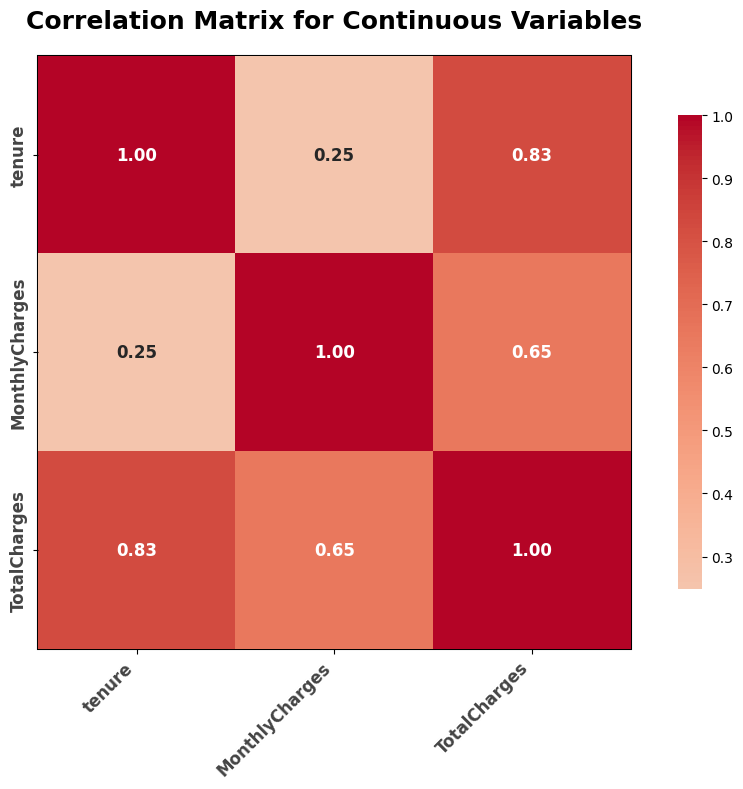

In [9]:

corr_matrix = telco_dataset[continuous_vars].corr()

# Create a sleek heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm", 
    center=0, 
    linewidths=0,  # No gridlines
    annot_kws={"size": 12, "weight": "bold"},  # Annotations formatting
    fmt=".2f",  # Two decimal places
    square=True,  # Keep the heatmap square
    cbar_kws={"orientation": "vertical", "shrink": 0.8}  # Tweak the color bar
)

# Title and axis customization
plt.title("Correlation Matrix for Continuous Variables", fontsize=18, weight='bold', pad=20)
plt.xticks(fontsize=12, rotation=45, ha='right', weight='bold', color="#444444")  # Dark gray axis labels
plt.yticks(fontsize=12, weight='bold', color="#444444")

# Remove spines for a cleaner look
plt.gca().spines.values()
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add rounded corners to the heatmap using background frame
plt.gca().patch.set_edgecolor('black')
plt.gca().patch.set_linewidth(1.5)
plt.gca().patch.set_facecolor('#f9f9f9')

# Adjust layout for better fit
plt.tight_layout()
plt.show()


In [ ]:
# Load the dataset
telco_dataset = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
telco_dataset['TotalCharges'].fillna(0, inplace=True)
telco_dataset = telco_dataset.drop(columns=['customerID'])

# Convert 'Churn' to binary for analysis
telco_dataset['Churn'] = telco_dataset['Churn'].map({'No': 0, 'Yes': 1})

# Step 1: Binning Continuous Variables
# Define bins and labels for tenure, MonthlyCharges, and TotalCharges
telco_dataset['tenure_bins'] = pd.qcut(telco_dataset['tenure'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
telco_dataset['MonthlyCharges_bins'] = pd.qcut(telco_dataset['MonthlyCharges'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
telco_dataset['TotalCharges_bins'] = pd.qcut(telco_dataset['TotalCharges'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# Drop original continuous columns
telco_dataset = telco_dataset.drop(columns=['tenure', 'MonthlyCharges', 'TotalCharges'])

# Step 2: Encode Categorical Variables
# One-hot encode binary variables, dropping the first category to reduce redundancy
binary_vars = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
telco_dataset = pd.get_dummies(telco_dataset, columns=binary_vars, drop_first=True)

# One-hot encode multi-category and binned variables
categorical_vars = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaymentMethod', 'tenure_bins', 'MonthlyCharges_bins', 'TotalCharges_bins'
]
telco_dataset = pd.get_dummies(telco_dataset, columns=categorical_vars, drop_first=True)

# Apply the Apriori Algorithm
# Set min_support to a threshold suitable for the data
frequent_itemsets = apriori(telco_dataset, min_support=0.4, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules.sort_values('confidence', ascending=False)

# Display the top 10 association rules
print("Top 7 Association Rules:")
print(rules.head(7))


Top 7 Association Rules:
                     antecedents             consequents  antecedent support  \
4  (InternetService_Fiber optic)      (PhoneService_Yes)            0.439585   
6            (MultipleLines_Yes)      (PhoneService_Yes)            0.421837   
5                  (Partner_Yes)      (PhoneService_Yes)            0.483033   
0         (PaperlessBilling_Yes)      (PhoneService_Yes)            0.592219   
2                  (gender_Male)      (PhoneService_Yes)            0.504756   
1             (PhoneService_Yes)  (PaperlessBilling_Yes)            0.903166   
3             (PhoneService_Yes)           (gender_Male)            0.903166   

   consequent support   support  confidence      lift  leverage  conviction  \
4            0.903166  0.439585    1.000000  1.107216  0.042567         inf   
6            0.903166  0.421837    1.000000  1.107216  0.040848         inf   
5            0.903166  0.438875    0.908583  1.005998  0.002617    1.059255   
0            0.903

C:\Users\DATA\AppData\Local\Temp\ipykernel_17144\3225615986.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  telco_dataset['TotalCharges'].fillna(0, inplace=True)
C:\Users\DATA\AppData\Roaming\Python\Python312\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


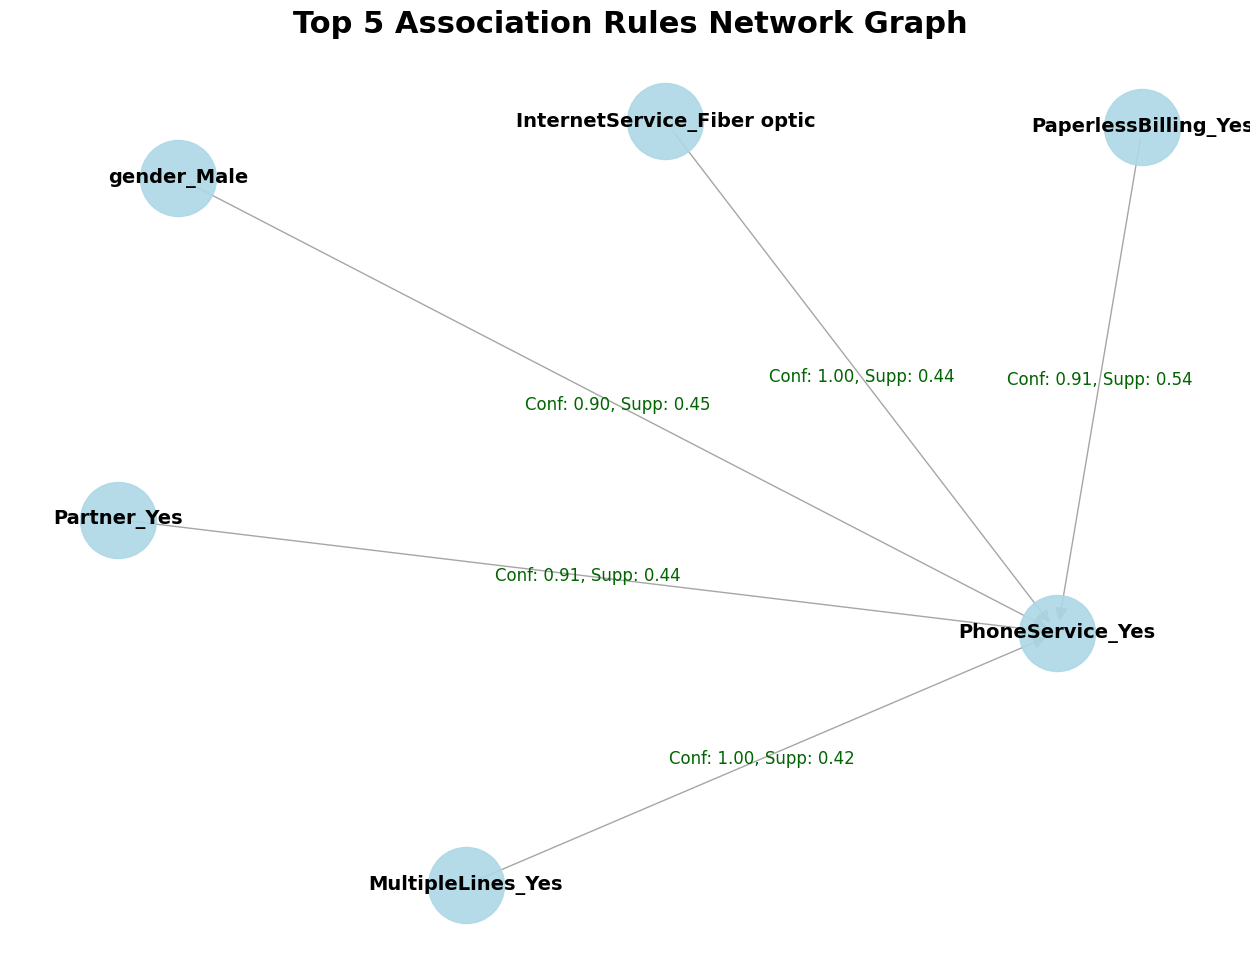

In [ ]:
# Select the top 7 rules based on confidence (you can change this to 'lift' or another metric)
top_rules = rules.nlargest(5, 'confidence')

# Create edges from the filtered rules
edges = []
for _, row in top_rules.iterrows():
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents']))
    edges.append((antecedents, consequents, {'confidence': row['confidence'], 'support': row['support']}))

# Create the graph
G = nx.DiGraph()
G.add_edges_from([(u, v, d) for u, v, d in edges])

# Plot the graph
plt.figure(figsize=(16, 12))  # Adjusted figure size for clarity
pos = nx.spring_layout(G, seed=42)  # Layout for consistent visualization

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="lightblue", alpha=0.9)

# Draw edges
nx.draw_networkx_edges(
    G, pos, arrowstyle='-|>', arrowsize=20, edge_color="gray", alpha=0.7
)

# Draw labels for nodes
nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold", font_color="black")

# Annotate edges with confidence and support
for u, v, data in G.edges(data=True):
    label = f"Conf: {data['confidence']:.2f}, Supp: {data['support']:.2f}"
    mid_x = (pos[u][0] + pos[v][0]) / 2
    mid_y = (pos[u][1] + pos[v][1]) / 2
    plt.text(mid_x, mid_y, label, fontsize=12, color="darkgreen", ha='center', va='center')

# Title and display adjustments
plt.title("Top 5 Association Rules Network Graph", fontsize=22, weight="bold")
plt.axis("off")
plt.show()


In [ ]:
df_encoded_binning = df_encoded.copy()

# Step 1: Binning Continuous Variables (equal frequency)
df_encoded_binning['tenure_bins'] = pd.qcut(df_encoded_binning['tenure'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df_encoded_binning['MonthlyCharges_bins'] = pd.qcut(df_encoded_binning['MonthlyCharges'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df_encoded_binning['TotalCharges_bins'] = pd.qcut(df_encoded_binning['TotalCharges'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

categorical_vars = [
'tenure_bins', 'MonthlyCharges_bins', 'TotalCharges_bins'
]
df_encoded_binning = pd.get_dummies(df_encoded_binning, columns=categorical_vars, drop_first=True)

# Drop original continuous columns
df_encoded_binning = df_encoded_binning.drop(columns=['tenure', 'MonthlyCharges', 'TotalCharges'])

# Apply the Apriori Algorithm
# Set min_support to a threshold suitable for the data
frequent_itemsets = apriori(df_encoded_binning, min_support=0.4, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)

# association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules.sort_values('confidence', ascending=False)

# Display the top 10 association rules
print("Top 10 Association Rules:")
print(rules.head(20))


Top 10 Association Rules:
                     antecedents         consequents  antecedent support  \
4  (InternetService_Fiber optic)      (PhoneService)            0.439585   
6            (MultipleLines_Yes)      (PhoneService)            0.421837   
5                      (Partner)      (PhoneService)            0.483033   
1             (PaperlessBilling)      (PhoneService)            0.592219   
3                       (gender)      (PhoneService)            0.504756   
0                 (PhoneService)  (PaperlessBilling)            0.903166   
2                 (PhoneService)            (gender)            0.903166   

   consequent support   support  confidence      lift  leverage  conviction  \
4            0.903166  0.439585    1.000000  1.107216  0.042567         inf   
6            0.903166  0.421837    1.000000  1.107216  0.040848         inf   
5            0.903166  0.438875    0.908583  1.005998  0.002617    1.059255   
1            0.903166  0.537271    0.907216  1.00

C:\Users\DATA\AppData\Roaming\Python\Python312\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


C:\Users\DATA\AppData\Local\Temp\ipykernel_17144\1622992750.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  telco_dataset['TotalCharges'].fillna(0, inplace=True)


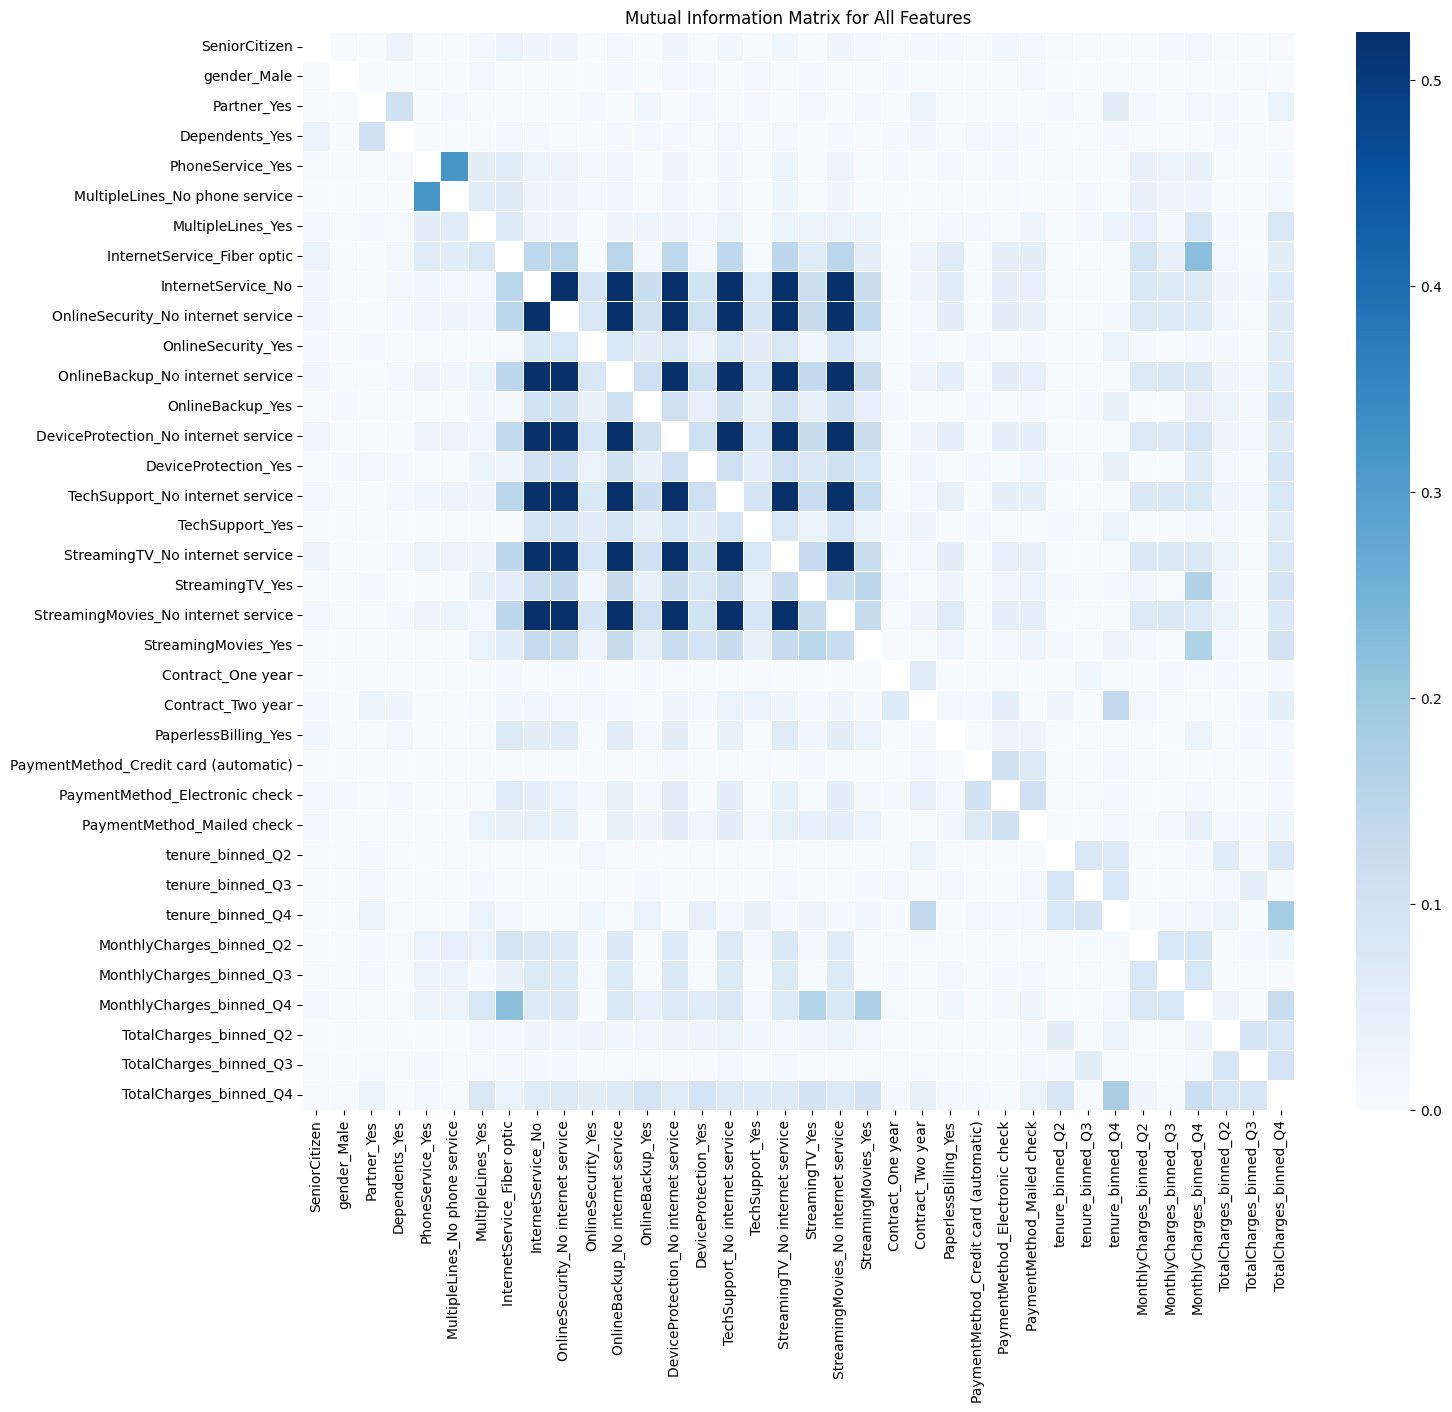

[('InternetService_No',
  'OnlineSecurity_No internet service',
  0.5234405468372978),
 ('StreamingMovies_No internet service',
  'DeviceProtection_No internet service',
  0.5232985618877024),
 ('OnlineBackup_No internet service',
  'InternetService_No',
  0.5232275694129047),
 ('TechSupport_No internet service',
  'StreamingTV_No internet service',
  0.5231565769381071),
 ('InternetService_No', 'TechSupport_No internet service', 0.5230855844633094),
 ('InternetService_No',
  'StreamingMovies_No internet service',
  0.5230855844633094),
 ('StreamingTV_No internet service',
  'OnlineBackup_No internet service',
  0.5230855844633094),
 ('InternetService_No',
  'OnlineBackup_No internet service',
  0.5230145919885117),
 ('OnlineSecurity_No internet service',
  'OnlineBackup_No internet service',
  0.5230145919885117),
 ('OnlineBackup_No internet service',
  'OnlineSecurity_No internet service',
  0.5230145919885117),
 ('OnlineBackup_No internet service',
  'StreamingTV_No internet service

In [ ]:
# Load the Telco Customer dataset and preprocess
telco_dataset = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")
telco_dataset['TotalCharges'].fillna(0, inplace=True)
df_colin = telco_dataset.copy()
df_colin = df_colin.drop(columns=['customerID', 'Churn'])  # Exclude target variable for feature-only analysis

# Step 1: Binning Continuous Variables Using Quartiles
# Define continuous variables for binning
continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Perform quartile-based binning for each continuous variable
for var in continuous_vars:
    df_colin[f'{var}_binned'] = pd.qcut(df_colin[var], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Drop the original continuous columns after binning
df_colin = df_colin.drop(columns=continuous_vars)

# One-hot encode all categorical and binned variables
df_encoded_colin = pd.get_dummies(df_colin, drop_first=True)

# Step 2: Calculate Mutual Information for Feature Relationships
# Calculate mutual information matrix for the features
mutual_info_matrix = pd.DataFrame(index=df_encoded_colin.columns, columns=df_encoded_colin.columns)

for col1 in df_encoded_colin.columns:
    for col2 in df_encoded_colin.columns:
        if col1 != col2:
            mi = mutual_info_classif(df_encoded_colin[[col1]], df_encoded_colin[col2])[0]
            mutual_info_matrix.loc[col1, col2] = mi

# Convert to float for plotting and analysis
mutual_info_matrix = mutual_info_matrix.astype(float)

# Identify feature pairs with high mutual information (e.g., > 0.3)
high_mi_pairs = []
threshold = 0.3
for col1 in mutual_info_matrix.columns:
    for col2 in mutual_info_matrix.index:
        if col1 != col2 and mutual_info_matrix.loc[col2, col1] > threshold:
            high_mi_pairs.append((col1, col2, mutual_info_matrix.loc[col2, col1]))

# Step 3: Plot Mutual Information Matrix
plt.figure(figsize=(16, 14))
sns.heatmap(mutual_info_matrix, annot=False, cmap="Blues", linewidths=0.5)
plt.title("Mutual Information Matrix for All Features")
plt.show()

high_mi_pairs_sorted = sorted(high_mi_pairs, key=lambda x: x[2], reverse=True)
high_mi_pairs_sorted[:20] 


In [ ]:
df_encoded.drop(columns=['PaymentMethod_Mailed check', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'StreamingTV_Yes',
                         'StreamingMovies_Yes', 'MultipleLines_Yes', 'MultipleLines_No phone service',
                         'PhoneService', 'gender', 'StreamingTV_No internet service', 'DeviceProtection_No internet service',
                         'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
                         'TechSupport_No internet service', 'StreamingMovies_No internet service'], inplace=True)


In [15]:
len(df_encoded.columns)

16

In [ ]:
# Step 1: Prepare data
# Separate features and target
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define pipeline with Min-Max Scaling
pipeline = ImbPipeline(steps=[
    ('scaler', MinMaxScaler()),  # Apply Min-Max Scaling
    ('rf', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

# Step 3: Define parameter grid for Random Forest
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Step 4: GridSearchCV without SMOTE
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model without SMOTE
best_rf = grid_search.best_estimator_

# Step 5: Evaluate Model Without SMOTE
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Metrics
metrics_without_smote = {
    "Classification Report": classification_report(y_test, y_pred),
    "Confusion Matrix": confusion_matrix(y_test, y_pred),
    "ROC AUC Score": roc_auc_score(y_test, y_pred_proba),
    "Accuracy": accuracy_score(y_test, y_pred)
}

# Step 6: GridSearchCV with SMOTE
pipeline_smote = ImbPipeline(steps=[
    ('scaler', MinMaxScaler()),  # Apply Min-Max Scaling
    ('smote', SMOTE(random_state=42)),  # Balance the training data
    ('rf', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

grid_search_smote = GridSearchCV(estimator=pipeline_smote, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_smote.fit(X_train, y_train)

# Best model with SMOTE
best_rf_smote = grid_search_smote.best_estimator_

# Step 7: Evaluate Model With SMOTE
y_pred_smote = best_rf_smote.predict(X_test)
y_pred_proba_smote = best_rf_smote.predict_proba(X_test)[:, 1]

# Metrics
metrics_with_smote = {
    "Classification Report": classification_report(y_test, y_pred_smote),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_smote),
    "ROC AUC Score": roc_auc_score(y_test, y_pred_proba_smote),
    "Accuracy": accuracy_score(y_test, y_pred_smote)
}

# Output metrics
print("Metrics Without SMOTE:")
print(metrics_without_smote)

print("\nMetrics With SMOTE:")
print(metrics_with_smote)

# Display best estimators
print("\nBest Model Without SMOTE:")
print(grid_search.best_estimator_)

print("\nBest Model With SMOTE:")
print(grid_search_smote.best_estimator_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Metrics Without SMOTE:
{'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.84      0.91      0.87      1035\n           1       0.67      0.53      0.59       374\n\n    accuracy                           0.80      1409\n   macro avg       0.75      0.72      0.73      1409\nweighted avg       0.80      0.80      0.80      1409\n', 'Confusion Matrix': array([[937,  98],
       [177, 197]], dtype=int64), 'ROC AUC Score': 0.8436836394636905, 'Accuracy': 0.8048261178140526}

Metrics With SMOTE:
{'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.90      0.75      0.82      1035\n           1       0.53      0.77      0.63       374\n\n    accuracy                           0.76      1409\n   macro avg       0.72      0.76      0.73      1409\nweighted avg      

In [17]:
print(grid_search.best_params_)

{'rf__max_depth': 10, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}


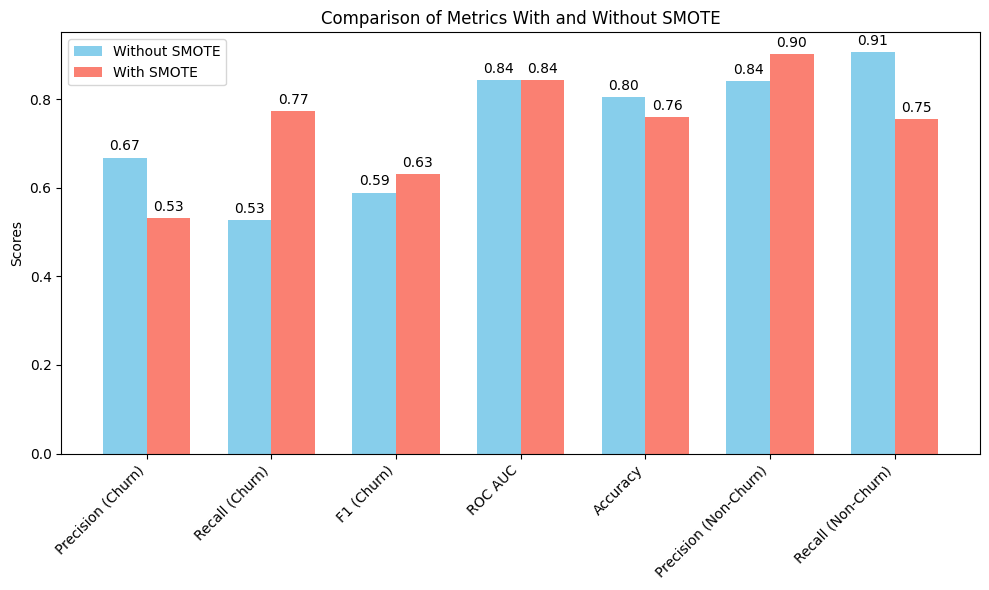

'./smote_vs_no_smote_metrics_comparison_with_accuracy.png'

In [ ]:
# Calculate metrics dynamically
metrics_without_smote = {
    "Precision (Churn)": precision_score(y_test, y_pred, pos_label=1),
    "Recall (Churn)": recall_score(y_test, y_pred, pos_label=1),
    "F1 (Churn)": f1_score(y_test, y_pred, pos_label=1),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba),
    "Accuracy": accuracy_score(y_test, y_pred)
}

metrics_with_smote = {
    "Precision (Churn)": precision_score(y_test, y_pred_smote, pos_label=1),
    "Recall (Churn)": recall_score(y_test, y_pred_smote, pos_label=1),
    "F1 (Churn)": f1_score(y_test, y_pred_smote, pos_label=1),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba_smote),
    "Accuracy": accuracy_score(y_test, y_pred_smote)
}

# Adding non-churn metrics dynamically
metrics_without_smote["Precision (Non-Churn)"] = precision_score(y_test, y_pred, pos_label=0)
metrics_without_smote["Recall (Non-Churn)"] = recall_score(y_test, y_pred, pos_label=0)

metrics_with_smote["Precision (Non-Churn)"] = precision_score(y_test, y_pred_smote, pos_label=0)
metrics_with_smote["Recall (Non-Churn)"] = recall_score(y_test, y_pred_smote, pos_label=0)

# Convert metrics to ordered lists for plotting
labels = list(metrics_without_smote.keys())
without_smote = list(metrics_without_smote.values())
with_smote = list(metrics_with_smote.values())

# Create bar plots
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, without_smote, width, label='Without SMOTE', color='skyblue')
bars2 = ax.bar(x + width/2, with_smote, width, label='With SMOTE', color='salmon')

# Add labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics With and Without SMOTE')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Annotate bars with their values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # Offset text
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

# Save plot as image for reports
plot_path = "./smote_vs_no_smote_metrics_comparison_with_accuracy.png"
fig.savefig(plot_path)

plot_path


In [ ]:
# Prepare data
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Identify continuous and categorical features
continuous_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X.columns if col not in continuous_features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), continuous_features),  # Apply Min-Max Scaling only to continuous features
        ('cat', 'passthrough', categorical_features)  # Leave categorical features as is
    ]
)

# Define the pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE for imbalanced data
    ('logreg', LogisticRegression(random_state=42, max_iter=500))  # Logistic Regression
])

# Define parameter grid for logistic regression
param_grid_lr = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs'],  # Solvers
    'logreg__penalty': ['l2']  # Regularization type
}

# GridSearchCV with 5-fold cross-validation
grid_search_lr = GridSearchCV(estimator=pipeline, param_grid=param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)  # Apply SMOTE inside the pipeline

# Best model from grid search
best_lr = grid_search_lr.best_estimator_

# Evaluate the model on the test set
y_pred_lr = best_lr.predict(X_test)
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Metrics
logistic_metrics = {
    "Classification Report": classification_report(y_test, y_pred_lr),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_lr),
    "ROC AUC Score": roc_auc_score(y_test, y_pred_proba_lr),
    "Accuracy": accuracy_score(y_test, y_pred_lr)  # Added accuracy
}

print("Logistic Regression Metrics:")
print(logistic_metrics)
print("\nBest Logistic Regression Estimator:")
print(grid_search_lr.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Logistic Regression Metrics:
{'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.91      0.71      0.80      1035\n           1       0.50      0.81      0.62       374\n\n    accuracy                           0.74      1409\n   macro avg       0.71      0.76      0.71      1409\nweighted avg       0.80      0.74      0.75      1409\n', 'Confusion Matrix': array([[733, 302],
       [ 70, 304]], dtype=int64), 'ROC AUC Score': 0.8399183652380583, 'Accuracy': 0.7359829666430092}

Best Logistic Regression Estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat', 'passthrough',
                                         

In [28]:
print(grid_search_lr.best_params_)

{'logreg__C': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


In [ ]:
# Random Forest with SMOTE results
rf_metrics = {
    "Model": "Random Forest",
    "Recall (Churn)": recall_score(y_test, y_pred_smote, pos_label=1),
    "Precision (Churn)": precision_score(y_test, y_pred_smote, pos_label=1),
    "F1-Score (Churn)": f1_score(y_test, y_pred_smote, pos_label=1),
    "F1-Weighted": f1_score(y_test, y_pred_smote, average='weighted'),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba_smote),
    "Accuracy": accuracy_score(y_test, y_pred_smote)
}

# Logistic Regression results
lr_metrics = {
    "Model": "Logistic Regression",
    "Recall (Churn)": recall_score(y_test, y_pred_lr, pos_label=1),
    "Precision (Churn)": precision_score(y_test, y_pred_lr, pos_label=1),
    "F1-Score (Churn)": f1_score(y_test, y_pred_lr, pos_label=1),
    "F1-Weighted": f1_score(y_test, y_pred_lr, average='weighted'),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba_lr),
    "Accuracy": accuracy_score(y_test, y_pred_lr)
}

# Combine results into a DataFrame
comparison_df = pd.DataFrame([rf_metrics, lr_metrics])

# Display the table
print(comparison_df)


                 Model  Recall (Churn)  Precision (Churn)  F1-Score (Churn)  \
0        Random Forest        0.772727           0.532228          0.630316   
1  Logistic Regression        0.812834           0.501650          0.620408   

   F1-Weighted   ROC AUC  Accuracy  
0     0.770880  0.842581  0.759404  
1     0.750571  0.839918  0.735983  


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409


Confusion Matrix:
[[799 236]
 [ 97 277]]

ROC AUC Score: 0.821058410188845

Accuracy: 0.7636621717530163


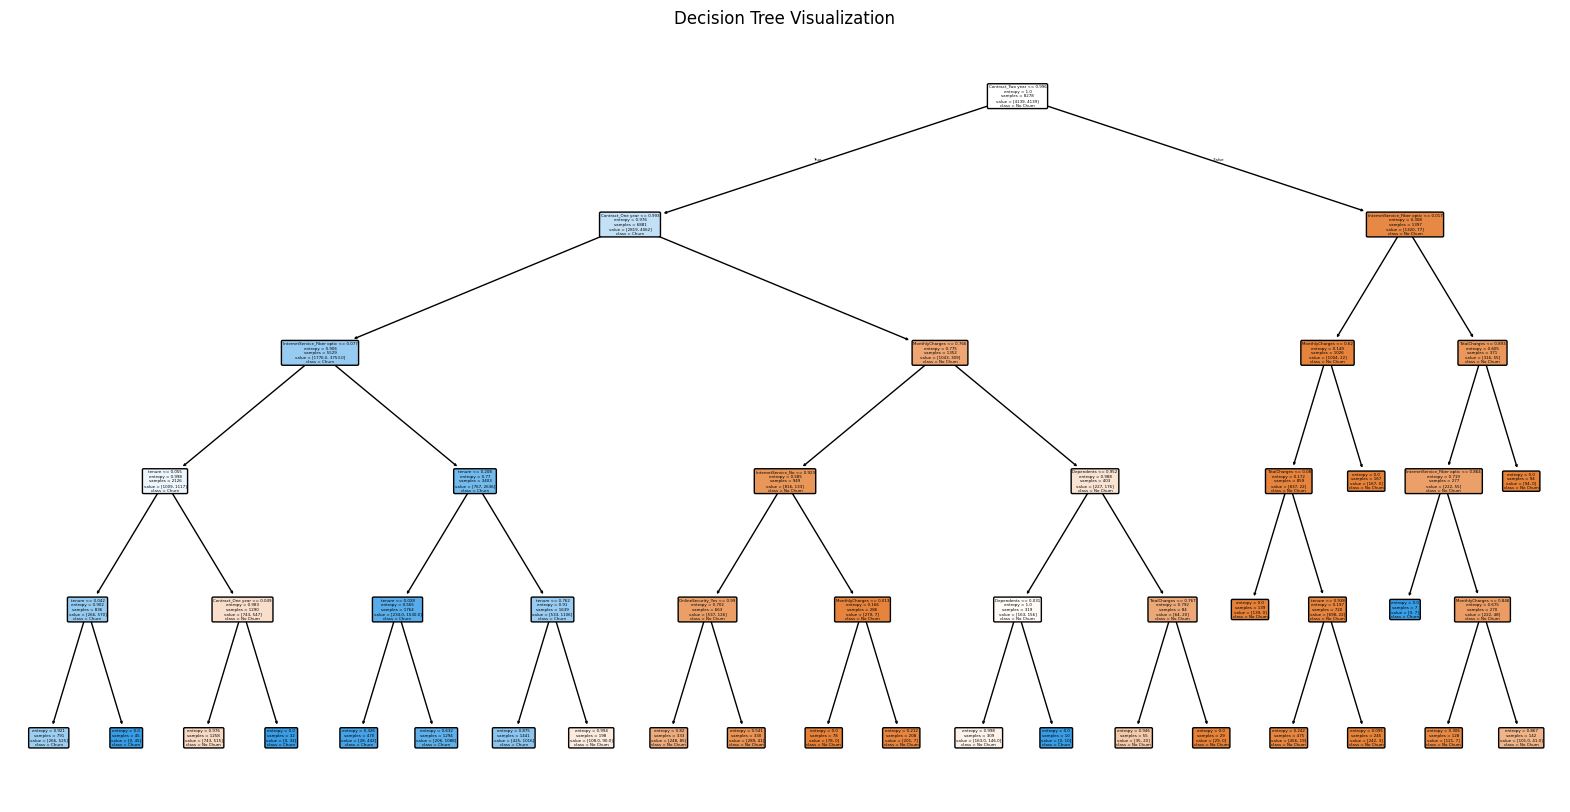


Comparison of Models:
                 Model  Recall (Churn)  Precision (Churn)  F1-Score (Churn)  \
0        Random Forest        0.772727           0.532228          0.630316   
1  Logistic Regression        0.812834           0.501650          0.620408   
2        Decision Tree        0.740642           0.539961          0.624577   

   F1-Weighted   ROC AUC  Accuracy  
0     0.770880  0.842581  0.759404  
1     0.750571  0.839918  0.735983  
2     0.773674  0.821058  0.763662  

Best Decision Tree Parameters:
{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 2}


In [ ]:
# Step 1: Prepare data
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define pipeline with SMOTE and Min-Max Scaling
pipeline = ImbPipeline(steps=[
    ('scaler', MinMaxScaler()),  # Normalize features
    ('smote', SMOTE(random_state=42)),  # Balance the training data
    ('dt', DecisionTreeClassifier(random_state=42))  # Decision Tree Classifier
])

# Step 3: Define parameter grid for Decision Tree
param_grid_dt = {
    'dt__max_depth': [3, 5, 10, None],  # Depth of the tree
    'dt__min_samples_split': [2, 5, 10],  # Minimum samples to split
    'dt__min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'dt__criterion': ['gini', 'entropy']  # Splitting criterion
}

# Step 4: GridSearchCV with 5-fold cross-validation
grid_search_dt = GridSearchCV(estimator=pipeline, param_grid=param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_dt.fit(X_train, y_train)  # SMOTE and scaling are handled in the pipeline

# Best model from GridSearchCV
best_dt = grid_search_dt.best_estimator_

# Step 5: Evaluate the best model on the test set
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Metrics
dt_metrics = {
    "Classification Report": classification_report(y_test, y_pred_dt),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_dt),
    "ROC AUC Score": roc_auc_score(y_test, y_pred_proba_dt),
    "Accuracy": accuracy_score(y_test, y_pred_dt)
}

# Print evaluation metrics
print("Classification Report:")
print(dt_metrics["Classification Report"])
print("\nConfusion Matrix:")
print(dt_metrics["Confusion Matrix"])
print("\nROC AUC Score:", dt_metrics["ROC AUC Score"])
print("\nAccuracy:", dt_metrics["Accuracy"])

# Step 6: Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt.named_steps['dt'],  # Access the decision tree from the pipeline
    feature_names=X.columns, 
    class_names=['No Churn', 'Churn'], 
    filled=True, 
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()

# Collect metrics for the Decision Tree model
dt_metrics_summary = {
    "Model": "Decision Tree",
    "Recall (Churn)": recall_score(y_test, y_pred_dt, pos_label=1),
    "Precision (Churn)": precision_score(y_test, y_pred_dt, pos_label=1),
    "F1-Score (Churn)": f1_score(y_test, y_pred_dt, pos_label=1),
    "F1-Weighted": f1_score(y_test, y_pred_dt, average='weighted'),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba_dt),
    "Accuracy": accuracy_score(y_test, y_pred_dt)
}

# Combine all model results into a single table
comparison_df = pd.DataFrame([rf_metrics, lr_metrics, dt_metrics_summary])
print("\nComparison of Models:")
print(comparison_df)

# Best parameters from grid search
print("\nBest Decision Tree Parameters:")
print(grid_search_dt.best_params_)


In [22]:
print(grid_search_dt.best_params_)


{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 2}


The root node of the decision tree is: Contract_Two year


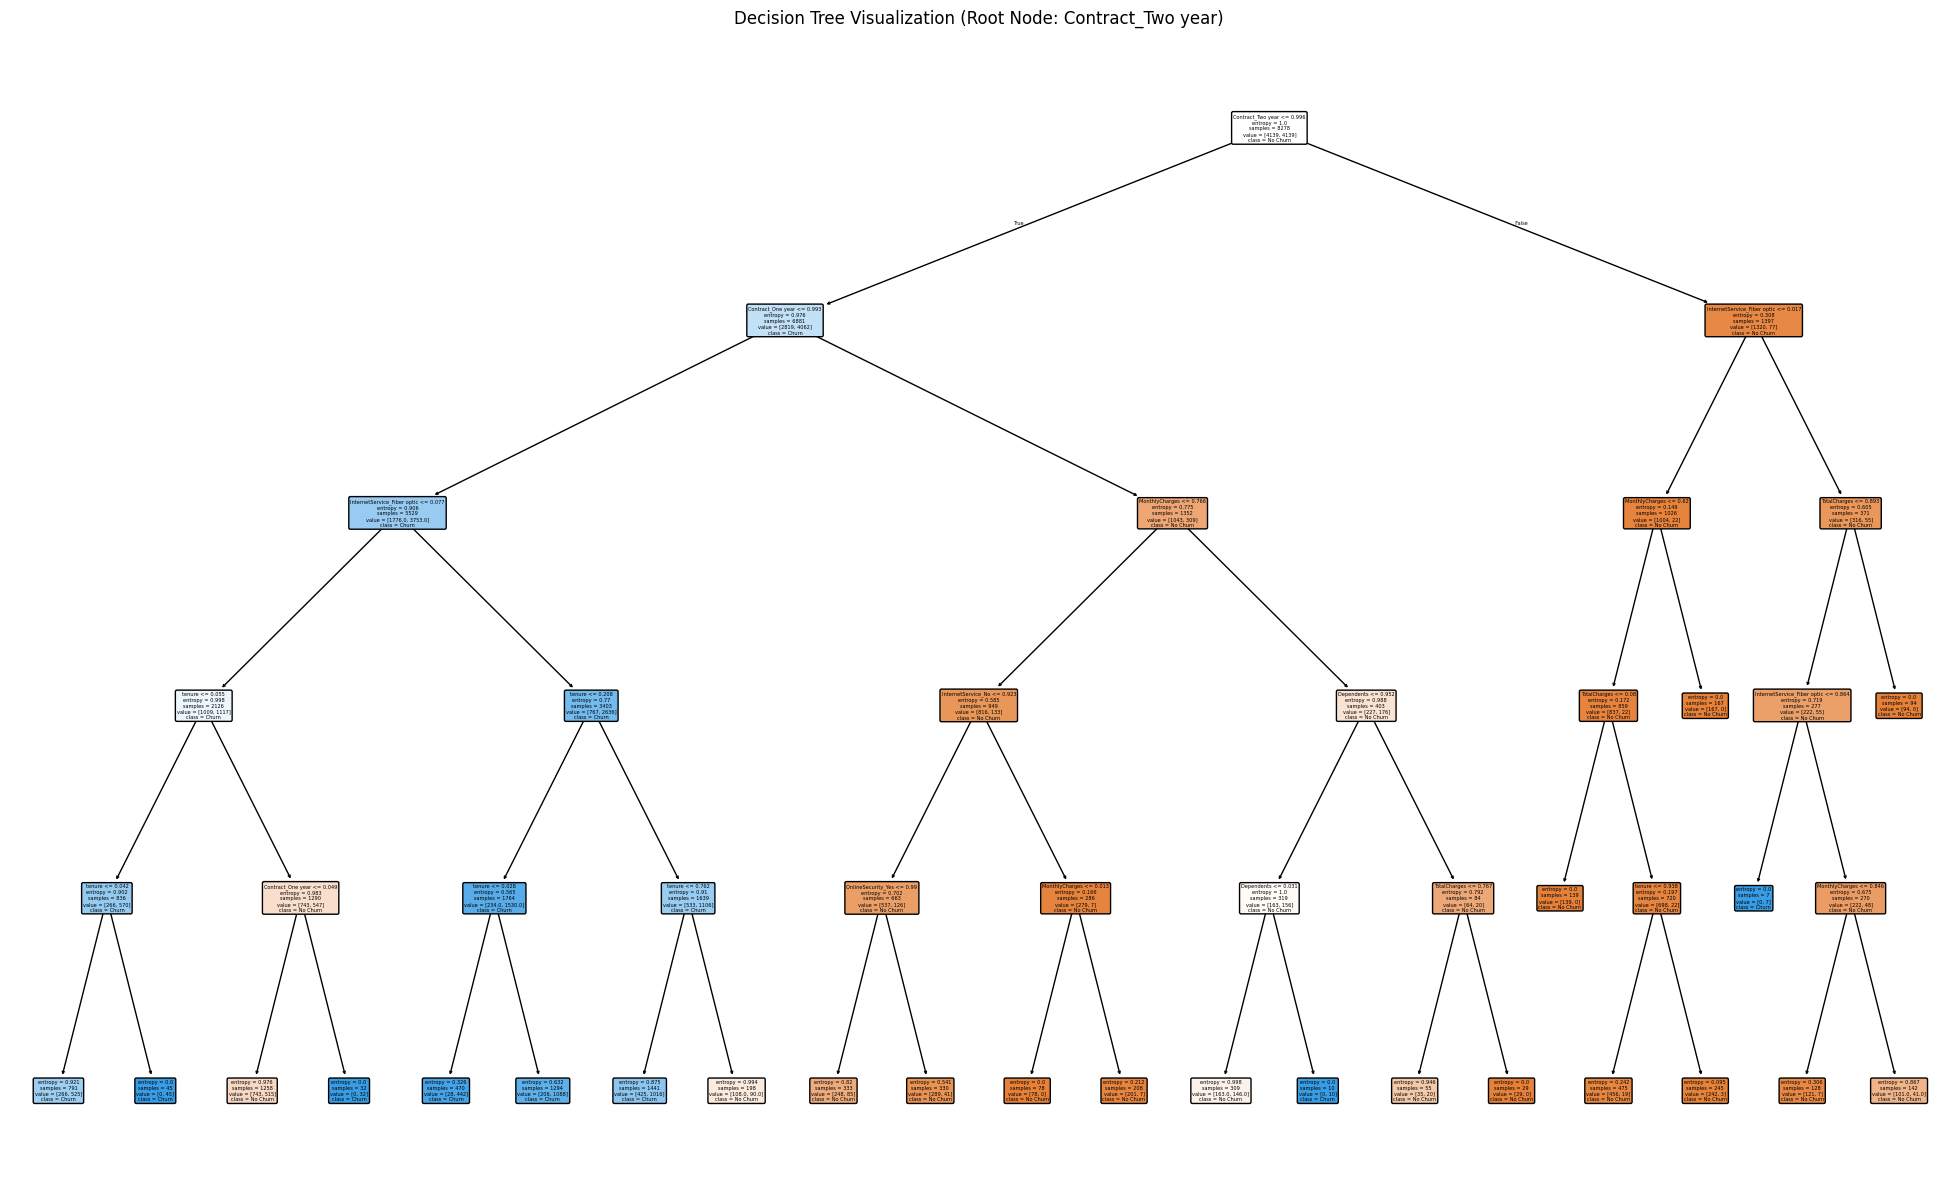

In [23]:
# Extract the DecisionTreeClassifier from the pipeline
decision_tree_model = best_dt.named_steps['dt']  # Replace 'dt' with the step name in your pipeline for the DecisionTreeClassifier

# Step 6: Identify the Root Node of the Decision Tree
root_feature_index = decision_tree_model.tree_.feature[0]  # Index of the root node feature
root_feature_name = X.columns[root_feature_index] if root_feature_index != -2 else "Leaf Node"

print(f"The root node of the decision tree is: {root_feature_name}")

# Optional: Plot the tree with a larger figure size for better visualization
plt.figure(figsize=(25, 15))
plot_tree(decision_tree_model, feature_names=X.columns, class_names=['No Churn', 'Churn'], filled=True, rounded=True)
plt.title(f"Decision Tree Visualization (Root Node: {root_feature_name})")
plt.show()


In [ ]:
# Step 1: Prepare data
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Identify continuous and categorical features
continuous_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X.columns if col not in continuous_features]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define preprocessing step for Min-Max Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), continuous_features),  # Scale only continuous variables
        ('cat', 'passthrough', categorical_features)  # Leave categorical variables unchanged
    ]
)

# Step 3: Define pipeline with SMOTE and Min-Max Scaler
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('smote', SMOTE(random_state=42)),  # Balance the training data
    ('mlp', MLPClassifier(max_iter=500, random_state=42))  # MLP Classifier
])

# Step 4: Define parameter grid for MLP
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 25)],  # Hidden layers
    'mlp__activation': ['relu', 'tanh'],  # Activation functions
    'mlp__solver': ['adam'],  # Optimizer
    'mlp__alpha': [0.0001, 0.001],  # Regularization parameter
    'mlp__learning_rate': ['constant', 'adaptive']  # Learning rate strategy
}

# Step 5: GridSearchCV with 5-fold cross-validation
grid_search_mlp = GridSearchCV(estimator=pipeline, param_grid=param_grid_mlp, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_mlp.fit(X_train, y_train)  # SMOTE and scaling are handled in the pipeline

# Best model from GridSearchCV
best_mlp = grid_search_mlp.best_estimator_

# Step 6: Evaluate the best model on the test set
y_pred_mlp = best_mlp.predict(X_test)
y_pred_proba_mlp = best_mlp.predict_proba(X_test)[:, 1]

# Metrics
mlp_metrics = {
    "Classification Report": classification_report(y_test, y_pred_mlp),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_mlp),
    "ROC AUC Score": roc_auc_score(y_test, y_pred_proba_mlp),
    "Accuracy": accuracy_score(y_test, y_pred_mlp)
}

# Print evaluation metrics
print("Classification Report:")
print(mlp_metrics["Classification Report"])
print("\nConfusion Matrix:")
print(mlp_metrics["Confusion Matrix"])
print("\nROC AUC Score:", mlp_metrics["ROC AUC Score"])
print("\nAccuracy:", mlp_metrics["Accuracy"])

# Step 7: Collect metrics for MLP model
mlp_metrics_summary = {
    "Model": "MLP Classifier",
    "Recall (Churn)": recall_score(y_test, y_pred_mlp, pos_label=1),
    "Precision (Churn)": precision_score(y_test, y_pred_mlp, pos_label=1),
    "F1-Score (Churn)": f1_score(y_test, y_pred_mlp, pos_label=1),
    "F1-Weighted": f1_score(y_test, y_pred_mlp, average='weighted'),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba_mlp),
    "Accuracy": accuracy_score(y_test, y_pred_mlp)
}

# Add MLP results to the comparison table
comparison_df = pd.DataFrame([rf_metrics, lr_metrics, dt_metrics_summary, mlp_metrics_summary])

print("Comparison of Models:")
print(comparison_df)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.52      0.79      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409


Confusion Matrix:
[[765 270]
 [ 77 297]]

ROC AUC Score: 0.8414993929060426

Accuracy: 0.7537260468417317
Comparison of Models:
                 Model  Recall (Churn)  Precision (Churn)  F1-Score (Churn)  \
0        Random Forest        0.772727           0.532228          0.630316   
1  Logistic Regression        0.812834           0.501650          0.620408   
2        Decision Tree        0.740642           0.539961          0.624577   
3       MLP Classifier        0.794118           0.523810          0.631243   

   F1-Weighted   ROC AUC  Accuracy  
0     0.770880  0.842581  

In [25]:
print("Best hyperparameters:", grid_search_mlp.best_params_)


Best hyperparameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}


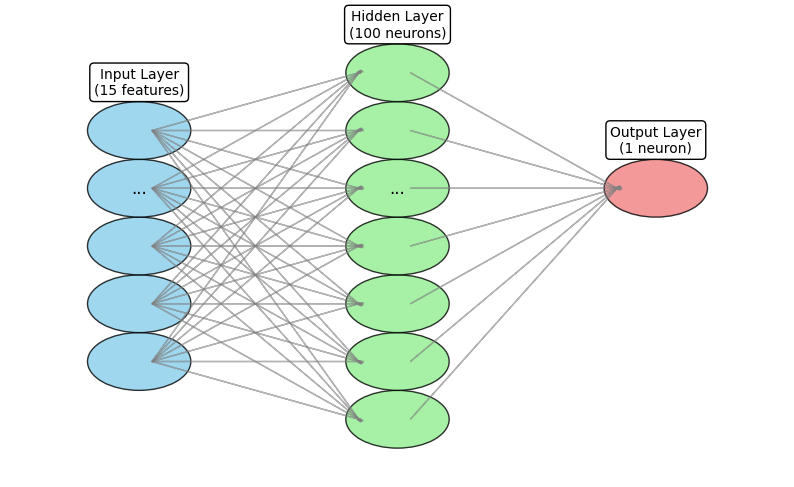

In [ ]:
def draw_balanced_neural_network(layers, activation):
    """
    Draw a balanced representation of the neural network with skipped neurons using dots.

    Parameters:
    - layers: List with the number of neurons in each layer. For example, [10, 50, 1].
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    # X-axis positions for layers
    x_positions = [i * 10 for i in range(len(layers))]  # Increased spacing between layers

    # Define how many neurons to show per layer
    max_neurons_to_show = 5  # Input layer
    hidden_layer_neurons_to_show = 7  # More neurons for hidden layers

    y_positions_by_layer = []  # To store positions for arrows

    # Define colors for each layer
    layer_colors = ["skyblue", "lightgreen", "lightcoral"]

    for layer_idx, neurons in enumerate(layers):
        # Adjust vertical spacing for the neurons
        vertical_spacing = 4  # Space between neurons
        if layer_idx == 1:  # Hidden layer
            if neurons <= hidden_layer_neurons_to_show:
                y_positions = [
                    i * vertical_spacing
                    for i in range(-neurons // 2, neurons // 2 + 1)
                ]
            else:
                y_positions = [
                    i * vertical_spacing
                    for i in range(-hidden_layer_neurons_to_show // 2, hidden_layer_neurons_to_show // 2)
                ]
                y_positions.append("...")  # Add dots for skipped neurons
        elif layer_idx == len(layers) - 1:  # Output layer
            y_positions = [0]  # Single neuron for binary classification
        else:  # Input layer
            if neurons <= max_neurons_to_show:
                y_positions = [
                    i * vertical_spacing
                    for i in range(-neurons // 2, neurons // 2 + 1)
                ]
            else:
                y_positions = [
                    i * vertical_spacing
                    for i in range(-max_neurons_to_show // 2, max_neurons_to_show // 2)
                ]
                y_positions.append("...")  # Add dots for skipped neurons

        # Draw neurons (circles)
        current_positions = []
        for y in y_positions:
            if y == "...":
                ax.text(
                    x_positions[layer_idx],
                    0,
                    "...",
                    fontsize=12,
                    ha="center",
                    va="center",
                )
            else:
                circle = patches.Circle(
                    (x_positions[layer_idx], y),
                    radius=2,  # Larger circles for better visibility
                    color=layer_colors[layer_idx % len(layer_colors)],  # Assign color for the layer
                    ec="black",
                    alpha=0.8,
                )
                ax.add_patch(circle)
                current_positions.append(y)

        y_positions_by_layer.append(current_positions)  # Store for connections

        # Annotate the layer with its type and neuron count
        if layer_idx == 0:
            label = f"Input Layer\n({neurons} features)"
        elif layer_idx == len(layers) - 1:
            label = f"Output Layer\n(1 neuron)"  # Adjusted for binary output
        else:
            label = f"Hidden Layer\n({neurons} neurons)"

        # Filter out '...' for determining max_y
        valid_y_positions = [y for y in y_positions if isinstance(y, (int, float))]
        max_y = max(valid_y_positions) if valid_y_positions else 0

        ax.text(
            x_positions[layer_idx],
            max_y + 2.5,
            label,
            fontsize=10,
            ha="center",
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        )

    # Draw arrows between layers
    for i in range(len(layers) - 1):
        for start_y in y_positions_by_layer[i]:  # From each neuron in the current layer
            for end_y in y_positions_by_layer[i + 1]:  # To each neuron in the next layer
                ax.arrow(
                    x_positions[i] + 0.5,  # Start slightly to the right of the circle
                    start_y,
                    8,  # Longer horizontal connection for increased spacing
                    end_y - start_y,  # Vertical difference
                    head_width=0.1,
                    head_length=0.2,
                    fc="gray",
                    ec="gray",
                    alpha=0.6,  # Make arrows subtle
                )

    # Dynamic adjustment of plot limits based on neuron positions
    all_y_positions = [pos for sublist in y_positions_by_layer for pos in sublist if isinstance(pos, (int, float))]
    min_y = min(all_y_positions) - 4
    max_y = max(all_y_positions) + 4
    plt.xlim(-5, x_positions[-1] + 5)
    plt.ylim(min_y, max_y)

    # Removed title here
    plt.show()


# Example usage
input_features = X_train.shape[1]  # Number of input features
hidden_layer_size = 100  # Single hidden layer with 50 neurons
output_neurons = 1  # One output for binary classification

layers = [input_features, hidden_layer_size, output_neurons]  # Neural network layers
activation = "tanh"  # Activation function from the best hyperparameters

draw_balanced_neural_network(layers, activation)


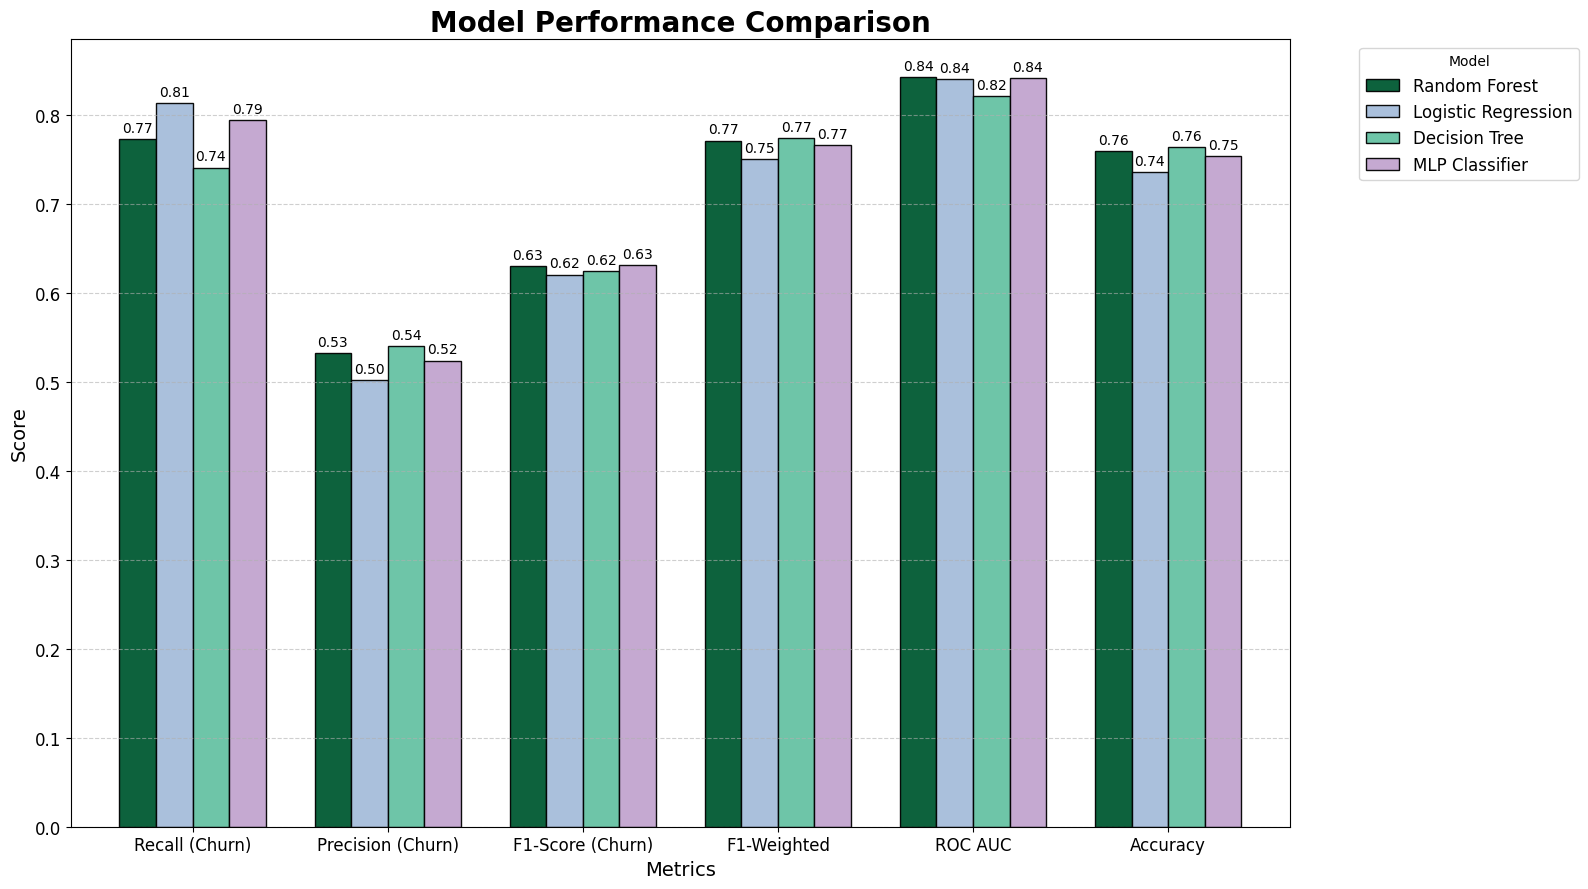

In [ ]:
# Transpose the DataFrame for easier plotting
metrics_df = comparison_df.set_index("Model").transpose()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(16, 9))

# Define the custom colors
colors = {
    "Random Forest": "#005a32",  # Dark green
    "Decision Tree": "#66c2a4",  # Light green
    "Logistic Regression": "#a6bddb",  # Light blue
    "MLP Classifier": "#c2a5cf"  # Light violet
}

# Apply colors to the models
color_list = [colors[model] for model in comparison_df["Model"]]
bar_chart = metrics_df.plot(
    kind="bar",
    ax=ax,
    color=color_list,
    edgecolor="black",
    alpha=0.95,  # Slight opacity for clarity
    width=0.75
)

# Add labels, formatting, and grid
ax.set_title("Model Performance Comparison", fontsize=20, fontweight='bold', color='black')
ax.set_ylabel("Score", fontsize=14)
ax.set_xlabel("Metrics", fontsize=14)
ax.set_xticks(range(len(metrics_df.index)))
ax.set_xticklabels(metrics_df.index, rotation=0, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add annotations to each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        annotation = f'{height:.2f}'
        ax.annotate(
            annotation,
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # Offset text above the bar
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=10
        )

# Save and show plot
plt.tight_layout()
bar_chart_path = "./model_comparison_with_f1_weighted.png"
plt.savefig(bar_chart_path)
plt.show()
